Unnamed: 0        -0.956082
VO2 Max           -0.855530
n Marathons run   -0.685504
BMI               -0.643922
Cadence           -0.492992
trained_10_week   -0.473501
trained_im        -0.391059
has_trainer       -0.171099
dtype: float64

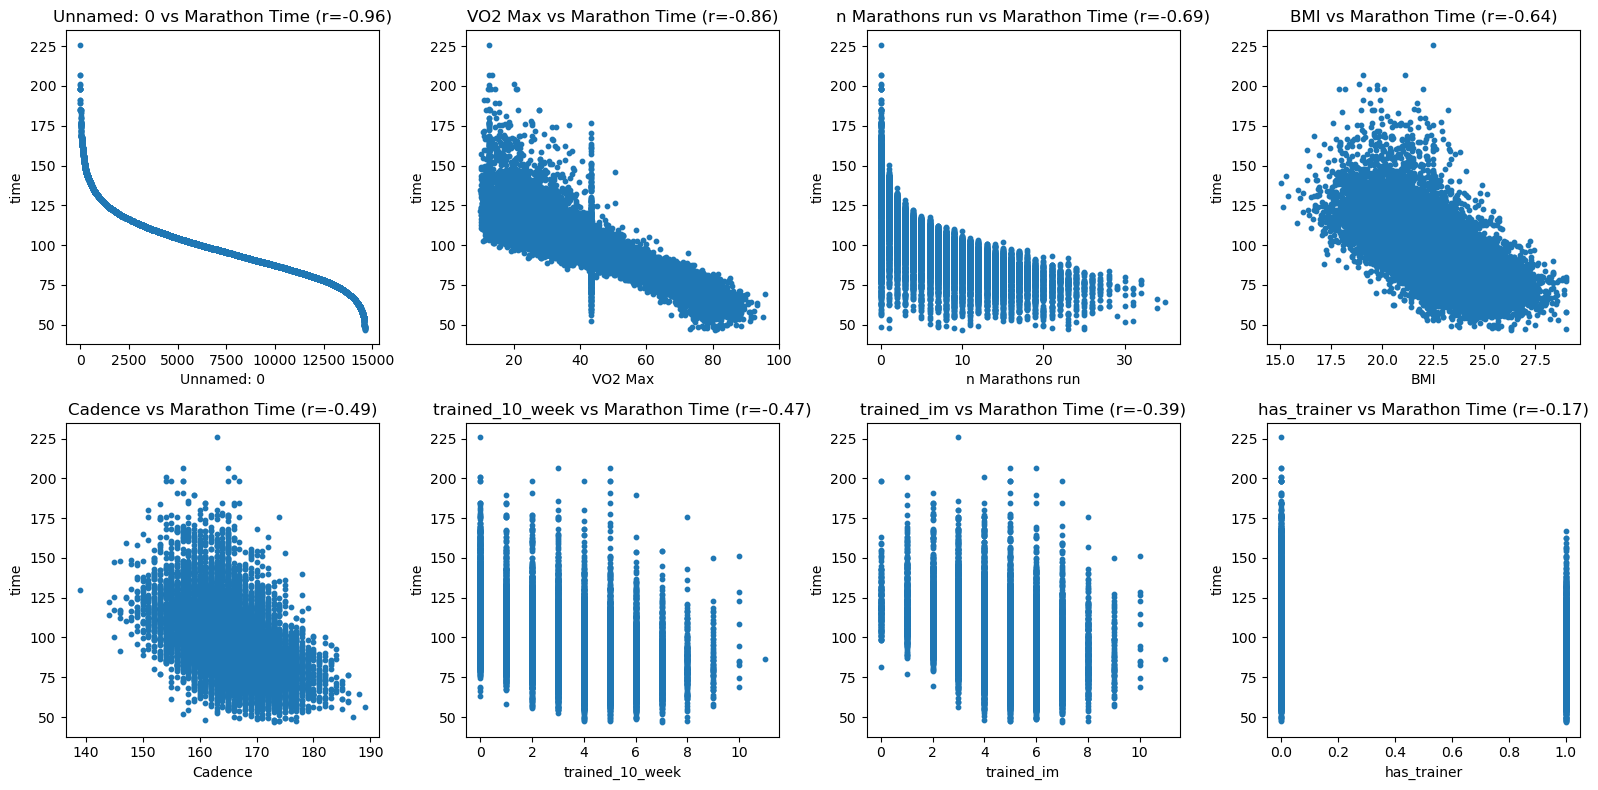

MSE: 93.0948 | RMSE: 9.6486 | R²: 0.7836
is_male              -0.763480
trained_10_week      -0.999372
trained_im           -0.811529
has_trainer          -0.234955
Age                   0.380688
VO2 Max              -10.420892
BMI                  -3.121592
n Marathons run      -3.877628
Cadence              -1.976248
intercept: 98.25526188235963


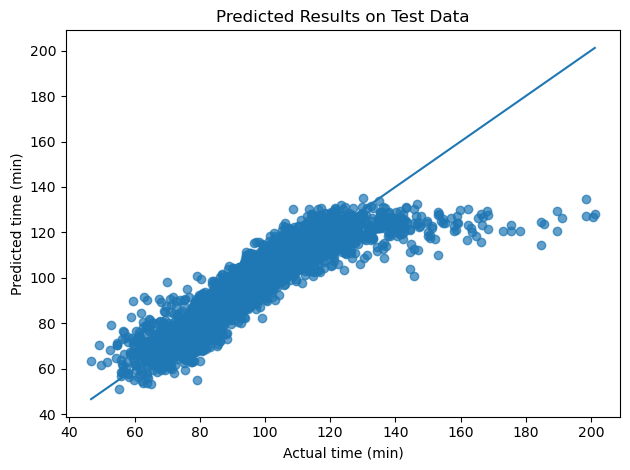

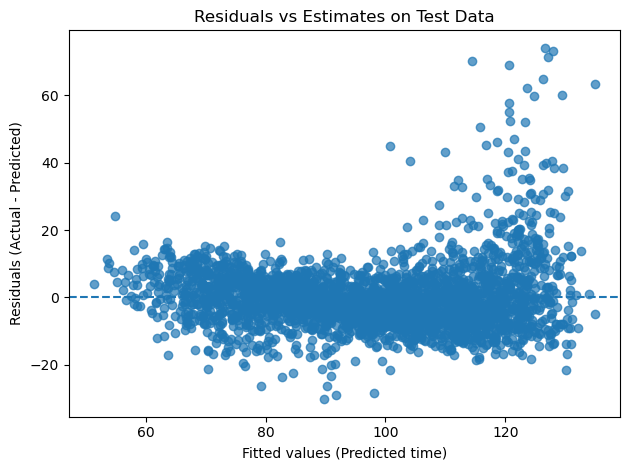

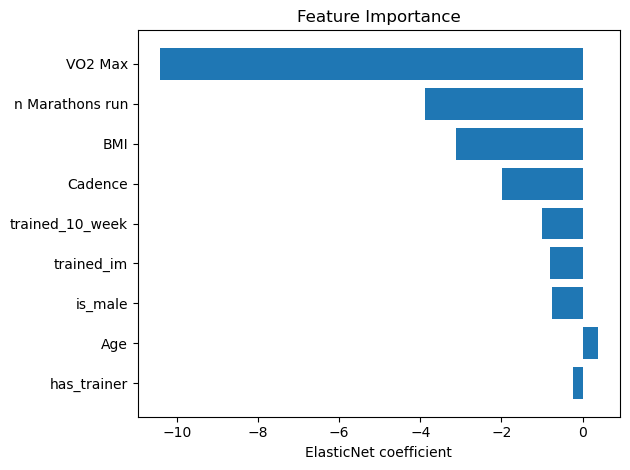

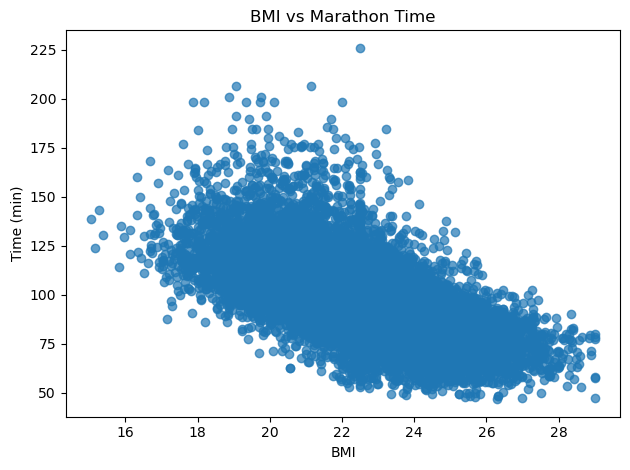

Predicted marathon time: 107.94 minutes


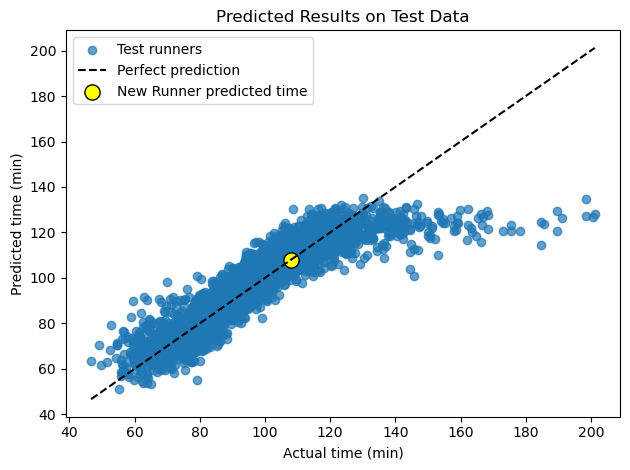

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import reduce
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.api as sm

import numpy as np
import matplotlib.pyplot as plt



df = pd.read_csv('runners.csv')
df.head(10)
TARGET = 'time'
ID_COLS = ['is_male', 'in_club', 'trained_10_week', 'trained_im', 'has_trainer', 'Age', 'VO2 Max', 'BMI', 'n Marathons run', 'Cadence']
X = df.drop(columns=[TARGET])
X = X.select_dtypes(include=[np.number])
y = df[TARGET]
corrs = {}
for c in X.columns:
    valid = df[[c, TARGET]].dropna()
    if len(valid) >= 30:
        corrs[c] = valid[c].corr(valid[TARGET])
corrs = pd.Series(corrs).dropna().sort_values(key=lambda s: s.abs(), ascending=False)

top8 = corrs.head(8)
display(top8)  
cols = top8.index.tolist()
n = len(cols)
rows = (n + 3)//4
plt.figure(figsize=(16, 4*rows))
for i, c in enumerate(cols, 1):
    ax = plt.subplot(rows, 4, i)
    valid = df[[c, TARGET]].dropna()
    ax.scatter(valid[c], valid[TARGET], s=10)
    ax.set_xlabel(c); ax.set_ylabel(TARGET)
    ax.set_title(f"{c} vs Marathon Time (r={valid[c].corr(valid[TARGET]):.2f})")
plt.tight_layout(); plt.show()
TARGET = 'time'
FEATURES = [
    'is_male', 'is_in_club',
    'trained_10_week', 'trained_im', 'has_trainer',
    'Age', 'VO2 Max', 'BMI', 'n Marathons run', 'Cadence'
]
FEATURES = [c for c in FEATURES if c in df.columns]
mask = df[FEATURES + [TARGET]].notnull().all(axis=1)
X = df.loc[mask, FEATURES]
y = df.loc[mask, TARGET]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=43
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=43))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f} | RMSE: {np.sqrt(mse):.4f} | R²: {r2:.4f}")

coef = pipe.named_steps["model"].coef_
intercept = pipe.named_steps["model"].intercept_
for name, w in zip(FEATURES, coef):
    print(f"{name:20s} {w: .6f}")
print("intercept:", intercept)
feature_names = FEATURES
y_hat_train = pipe.predict(X_train)
y_hat_test  = pipe.predict(X_test)
res_train = y_train - y_hat_train
res_test  = y_test  - y_hat_test

plt.figure()
plt.scatter(y_test, y_hat_test, alpha=0.7)
lims = [min(y_test.min(), y_hat_test.min()), max(y_test.max(), y_hat_test.max())]
plt.plot(lims, lims)  # 45-degree line
plt.xlabel("Actual time (min)")
plt.ylabel("Predicted time (min)")
plt.title("Predicted Results on Test Data")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(y_hat_test, res_test, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values (Predicted time)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Estimates on Test Data")
plt.tight_layout()
plt.show()
enet = pipe.named_steps["model"]
coefs = enet.coef_
order = np.argsort(np.abs(coefs))[::-1]
sorted_names = np.array(feature_names)[order]
sorted_coefs = coefs[order]

plt.figure()
ypos = np.arange(len(sorted_names))
plt.barh(ypos, sorted_coefs)
plt.yticks(ypos, sorted_names)
plt.gca().invert_yaxis()
plt.xlabel("ElasticNet coefficient")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()
plt.figure()
plt.scatter(df['BMI'], df['time'], alpha=0.7)
plt.xlabel("BMI")
plt.ylabel("Time (min)")
plt.title("BMI vs Marathon Time")
plt.tight_layout()
plt.show()
new_runner = pd.DataFrame([{
    'is_male': 0,
    'trained_10_week': 2,
    'trained_im': 4,
    'has_trainer': 1,
    'Age': 17,
    'VO2 Max': 52,
    'BMI': 19,
    'n Marathons run': 0,
    'Cadence': 155
}])

predicted_time = pipe.predict(new_runner)[0]
print(f"Predicted marathon time: {predicted_time:.2f} minutes")
plt.figure()
plt.scatter(y_test, y_hat_test, alpha=0.7, label="Test runners")

lims = [min(y_test.min(), y_hat_test.min()), max(y_test.max(), y_hat_test.max())]
plt.plot(lims, lims, color='black', linestyle='--', label="Perfect prediction")
plt.scatter(predicted_time, predicted_time, color='Yellow', s=120, edgecolor='black', label="New Runner predicted time")
plt.xlabel("Actual time (min)")
plt.ylabel("Predicted time (min)")
plt.title("Predicted Results on Test Data")
plt.legend()
plt.tight_layout()
plt.show()
